<a href="https://colab.research.google.com/github/Rocknroll-nerd/statistic/blob/main/hw_anova__genesipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Поскольку без поправок множественных сравнений нельзя попарно сравнивать группы и применять к ним критерий стьюдента (из-за увеличения количества сравнений вероятность случайно получить хотя бы одно значимое различие $p<\alpha$ случайно при постоянном $\alpha$ будет стремиться к 1, при этом вероятно оно и не существенно), то есть повышается вероятность совершения ошибки первого рода. Проведем дисперсионный анализ или Anova c  критерием Тьюки  

Сравним средние в датасете.  Четыре группы на однофакторный дисперсионный анализ, проверяем $H_0$ гипотезу – средние по этим группам равны. Гипотеза –  имеются, по крайней мере, две группы, отличающиеся средними значениями между собой

In [ ]:
!pip install arviz

In [ ]:
!pip install pymc3 --upgrade

In [ ]:
import numpy as np
from scipy import stats
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (6,3)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
genes = "https://stepik.org/media/attachments/lesson/8083/genetherapy.csv"

df = pd.read_csv(genes)

df.head()
df['group_id'] = pd.Categorical(df['Therapy']).codes

In [ ]:
df

,expr,Therapy,group_id
0,100,A,0
1,96,A,0
2,101,A,0
3,95,A,0
4,103,A,0
5,99,A,0
6,97,A,0
7,96,A,0
8,98,A,0
9,106,A,0


In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [ ]:
results = ols('expr ~ C(group_id)', data=df).fit()
print(results.summary())
aov_table = sm.stats.anova_lm(results, typ=2)
print(aov_table)
print(stats.levene(df[df.group_id==0]['expr'], df[df.group_id==3]['expr']))
print(stats.shapiro(results.resid))
mc = MultiComparison(df['expr'], df['group_id'])
mc_results = mc.tukeyhsd()
print(f"истинные средние по группам ")
print(mc_results)

                            OLS Regression Results                            
Dep. Variable:                   expr   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     8.037
Date:                Thu, 25 Jun 2020   Prob (F-statistic):           0.000152
Time:                        09:54:16   Log-Likelihood:                -177.46
No. Observations:                  60   AIC:                             362.9
Df Residuals:                      56   BIC:                             371.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           99.7333      1.245  

In [ ]:
df.groupby('Therapy').describe()

expr                                   ... group_id                    
        count       mean       std   min   25%  ...      min  25%  50%  75%  max
Therapy                                         ...                             
A        15.0  99.733333  4.165619  95.0  96.0  ...      0.0  0.0  0.0  0.0  0.0
B        15.0  98.800000  5.894307  84.0  95.0  ...      1.0  1.0  1.0  1.0  1.0
C        15.0  94.400000  5.193402  85.0  91.0  ...      2.0  2.0  2.0  2.0  2.0
D        15.0  92.333333  3.735289  85.0  90.5  ...      3.0  3.0  3.0  3.0  3.0

[4 rows x 16 columns]

между группами A-C, A-D, B-D среднее отличается, достаточно большая F-статистика и стд примерно равны. можно говорить об отвергнутой 0 гипотезе. Ниже то же самое, но с помощью pymc и посмотрела различия по континентам в датасете

In [ ]:
with pm.Model() as genes_model:
    mean = pm.Normal('mean', mu=df.expr.mean(), sd=2*df.expr.std(),  shape=(4,))
    sd = pm.Uniform('sigma', lower=0 , upper= 5, shape=(4,))
    # Define the nuisance parameter nu for the T distribution
    nu = pm.Exponential('nu', lam=1/29., shape=(4,)) + 1
    
    # Define the likelihood.
    like = pm.StudentT('likelihood', 
                       nu=nu[df['group_id']],
                       mu=mean[df['group_id']], 
                       sd=sd[df['group_id']], 
                       observed=df['expr'])
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu, sigma, mean]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 15 seconds.


In [ ]:
az.summary(trace, credible_interval=.95).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean[0],99.641,1.107,97.570,101.791,0.019,0.014,3362.0,3359.0,3370.0,2386.0,1.0
mean[1],99.100,1.288,96.668,101.426,0.020,0.014,4297.0,4288.0,4343.0,3013.0,1.0
mean[2],94.634,1.220,92.371,97.031,0.018,0.013,4757.0,4752.0,4754.0,2568.0,1.0
mean[3],92.391,0.991,90.515,94.274,0.015,0.011,4147.0,4147.0,4152.0,2500.0,1.0
sigma[0],4.036,0.555,3.100,4.985,0.010,0.008,2834.0,2546.0,2349.0,1421.0,1.0
sigma[1],4.372,0.496,3.477,4.999,0.008,0.006,3559.0,3511.0,2845.0,1949.0,1.0
sigma[2],4.369,0.464,3.560,5.000,0.008,0.006,3148.0,3033.0,2441.0,1740.0,1.0
sigma[3],3.701,0.632,2.748,4.994,0.014,0.010,2152.0,1923.0,1982.0,1387.0,1.0
nu[0],34.524,29.971,0.874,88.043,0.470,0.373,4065.0,3236.0,3945.0,2714.0,1.0
nu[1],19.472,22.398,0.007,59.202,0.356,0.268,3967.0,3483.0,3394.0,2394.0,1.0


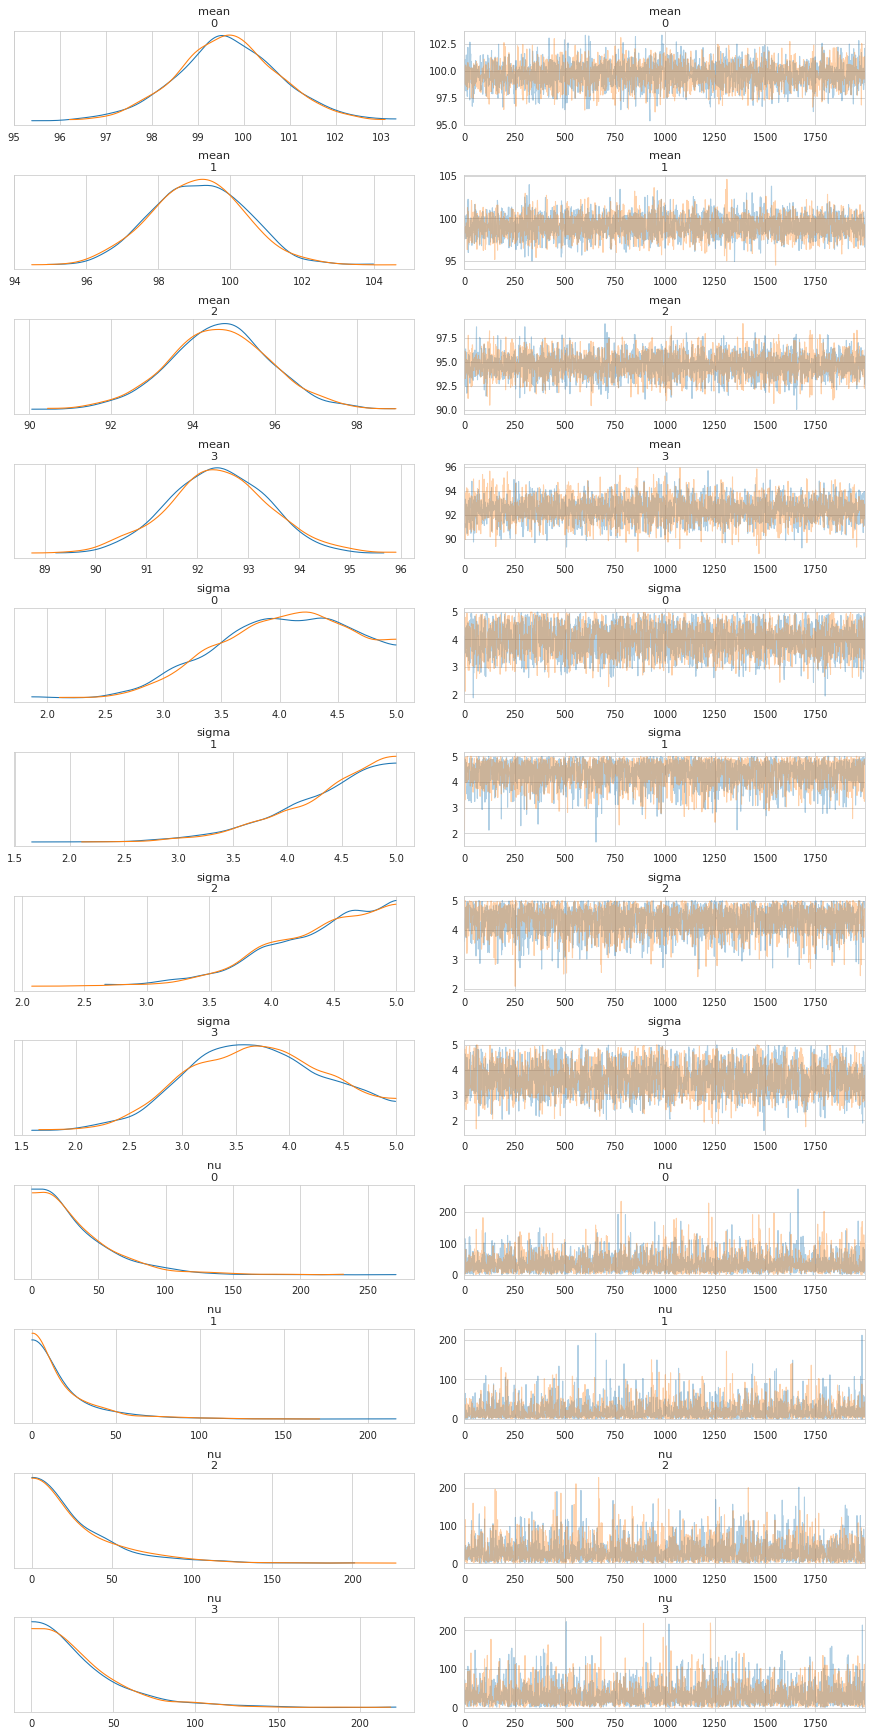

In [ ]:
az.plot_trace(trace);

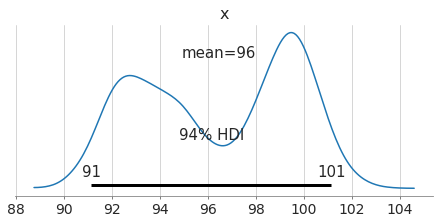

In [ ]:
az.plot_posterior(trace['mean']);

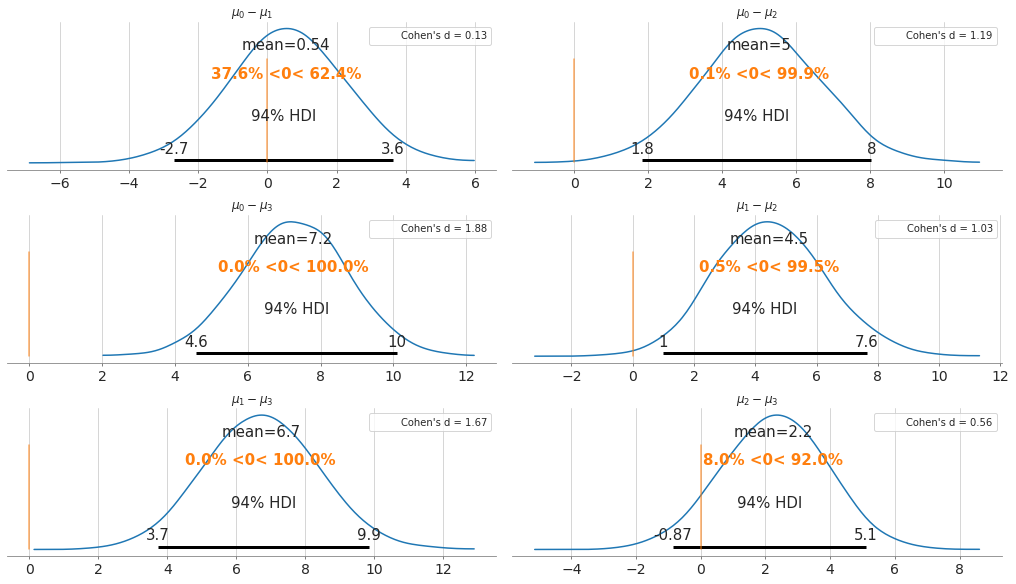

In [ ]:
n_groups=4
def plot_diff_effects(n_groups, trace_group):
    comparisons = [(i, j) for i in range(n_groups) for j in range(i+1, n_groups)]
    pos = [(k, l) for k in range(n_groups-1) for l in (0, 1)]
    _, ax = plt.subplots(len(comparisons)//2, 2, figsize=(14, 8), constrained_layout=True)
    for (i, j), (k, l) in zip(comparisons, pos):
        means_diff = trace_group['mean'][:, i] - trace_group['mean'][:, j]
        d_cohen = (means_diff / np.sqrt((trace_group['sigma'][:, i]**2 +
            trace_group['sigma'][:, j]**2) / 2)).mean()
        az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
        ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
        ax[k, l].plot(0, label=f"Cohen's d = {d_cohen:.2f}",alpha=0)
        ax[k, l].legend()
plot_diff_effects(n_groups, trace)    


#Задание

Посмотрите различаются ли какие-то показатели по континентам

In [ ]:
cancer= pd.read_csv("https://raw.githubusercontent.com/bioinformatics-core-shared-training/intermediate-stats/master/globalBreastCancerRisk.csv")
cancer

,country,continent,year,lifeExp,pop,gdpPercap,NewCasesOfBreastCancerIn2002,AlcoholComsumption,BloodPressure,BodyMassIndex,Cholestorol,Smoking
0,Afghanistan,Asia,2002,42.129,25268405,726.734055,26.8,0.02,124.2085,20.65274,4.295170,NaN
1,Albania,Europe,2002,75.651,3508512,4604.211737,57.4,6.68,129.0609,25.27082,4.918646,4.0
2,Algeria,Africa,2002,70.994,31287142,5288.040382,23.5,0.96,130.4024,25.69948,4.848951,0.3
3,Angola,Africa,2002,41.003,10866106,2773.287312,23.1,5.40,129.9282,22.26093,4.499115,NaN
4,Argentina,Americas,2002,74.340,38331121,8797.640716,73.9,10.00,119.6538,26.70460,5.143871,25.4
...,...,...,...,...,...,...,...,...,...,...,...,...
118,Uruguay,Americas,2002,75.307,3363085,7727.002004,83.1,8.14,124.6190,25.88269,5.001928,28.0
119,Venezuela,Americas,2002,72.766,24287670,8605.047831,34.3,8.23,124.9664,27.32819,4.802348,27.0
120,Vietnam,Asia,2002,73.017,80908147,1764.456677,16.2,3.77,121.4875,20.47612,4.565701,2.5
121,Zambia,Africa,2002,39.193,10595811,1071.613938,13.0,3.85,129.7063,22.45268,4.455595,5.0


In [ ]:
results = ols('lifeExp ~ C(continent)', data=cancer).fit()
print(results.summary())
aov_table = sm.stats.anova_lm(results, typ=2)
print(aov_table)
print(stats.levene(cancer[cancer.continent=='Asia']['lifeExp'], cancer[cancer.continent=='Zimbabwe']['lifeExp']))
print(stats.shapiro(results.resid))
mc = MultiComparison(cancer['lifeExp'], cancer['continent'])
mc_results = mc.tukeyhsd()
print(f"истинные средние по группам ")
print(mc_results)

                            OLS Regression Results                            
Dep. Variable:                lifeExp   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     56.78
Date:                Thu, 25 Jun 2020   Prob (F-statistic):           1.26e-26
Time:                        10:36:29   Log-Likelihood:                -417.29
No. Observations:                 123   AIC:                             844.6
Df Residuals:                     118   BIC:                             858.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [ ]:
results = ols('pop ~ C(continent)', data=cancer).fit()
print(results.summary())
aov_table = sm.stats.anova_lm(results, typ=2)
print(aov_table)
mc = MultiComparison(cancer['pop'], cancer['continent'])
mc_results = mc.tukeyhsd()
print(f"истинные средние по группам ")
print(mc_results)

                            OLS Regression Results                            
Dep. Variable:                    pop   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     2.964
Date:                Thu, 25 Jun 2020   Prob (F-statistic):             0.0225
Time:                        12:05:44   Log-Likelihood:                -2484.5
No. Observations:                 123   AIC:                             4979.
Df Residuals:                     118   BIC:                             4993.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Можно сказать, что данные популяции практически не различаются (за исключением Африки и Азии), а вот продолжительность жизни по континентам довольно различна